#  Enviando solicitudes de Inferencia al Motor de OpenVINO
Una vez conocidos los métodos de las clases `IECore` y `IENetwork`, es hora de introducir otra clase de mucha importancia para OpenVINO, que permite enviar solicitudes de Inferencia al motor de OpenVINO, esta clase se llama `ExecutableNetwork` y este objeto se crea cuando cargamos a un `IECore` con uno de `IENetwork` y seleccionamos el Hardware de inferencia deseado. Pero para ello, hay que primero verificar que todas las capas estén soportadas por nuestro dispositivo. Pero primero, hay que inicializar las variables de entorno y descargar si hace falta el anterior modelo de ejemplo.

## Inicializar las variables de Entorno
Como siempre, hay que inicializar las variables de entorno de OpenVINO, por favor **ejecutar** la celda correspondiente: 
- *Windows*

In [ ]:
%%cmd
"C:\Program Files (x86)\Intel\openvino_2021\bin\setupvars.bat"

- *Linux*

In [4]:
%%bash
source /opt/intel/openvino_2021/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


## Descargar el archivo de ejemplo(si es que no ha sido descargado aún)

In [5]:
import os, sys
nombre_modelo = "person-detection-retail-0013"
ruta_archivo = os.getcwd()
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
ruta_modelo_bin = ruta_modelo_xml.split(".")[0] + ".bin" #Cambiar la extensión de modelo a bin 

if (not os.path.isfile(ruta_modelo_xml)) and (not os.path.isfile(ruta_modelo_bin)):
    if sys.platform == "win32":
        ruta_model_downloader="C:\Program Files (x86)\Intel\openvino_2021\deployment_tools\tools\model_downloader\downloader.py"
        !python {ruta_model_downloader} --name {nombre_modelo}
        print("Ruta donde se guardó el archivo: {}".format(ruta_archivo))
    elif sys.platform == "linux":
        ruta_model_downloader="/opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py"
        !python3 {ruta_model_downloader} --name {nombre_modelo}
        print("Ruta donde se guardó el archivo: {}".format(ruta_archivo))
else:
    print("Archivos actualmente descargados en {}{}".format(ruta_archivo, ruta_modelo_xml))

Archivos actualmente descargados en /home/josejacomeb/Documents/Workshop-ESPEL-MCT-2021/Sección 4intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml


## Revisando la compatibilidad de las capas con nuestro dispositivo
Debido al diferente conjunto de instrucciones de cada dispositivo de inferencia y a las propias características de frameworks de Deep Learning, no todas las capas son compatibles con el dispositivo, entonces es útil comprobar esto al inicio, para que de que fuera el caso, usar una selección heterogénea para suplir esa deficiencia, eso se puede realizar con el siguiente código(se puede comentar y descomentar la variable `nombre_dispositivo_inferencia` para probar con los demás dispositivos):

**Nota:** En caso de no poder ejecutar el código anterior, desde el CMD de Windows o Terminal de Linux, primero inicializar las variables de entorno en el terminal y luego ejecutar el Jupyter Notebook.


In [24]:
#Cargar las clases de IECore, IENetwork
from openvino.inference_engine import IECore

ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
ruta_modelo_bin = ruta_modelo_xml.split(".")[0] + ".bin" #Cambiar la extensión de modelo a bin 

core = IECore() #Inicializo el objeto IECore
"""
Inicializo el objeto de tipo IENetwork a 
través de la función core.read_network
"""
network = core.read_network(model=ruta_modelo_xml, weights=ruta_modelo_bin) 

#CPU es el Dispositivo de Prueba, descomentar los otros para probar con los demás
nombre_dispositivo_inferencia = "CPU" 
#nombre_dispositivo_inferencia = 'GPU'
#nombre_dispositivo_inferencia = 'MYRIAD'

resultado_capas = core.query_network(network, nombre_dispositivo_inferencia)
capas_no_soportadas = ""
for capa, dispositivo in resultado_capas.items():
    if dispositivo != nombre_dispositivo_inferencia:
        capas_no_soportadas += capa
        capas_no_soportadas += '\n'
if capas_no_soportadas:
    print("Capas no soportadas para el dispositivo: {}\n {}".format(dispositivo, capas_no_soportadas))
    print("Se recomienda verificar en los demás dispositivos y hacer una ejecución heterogénea")
else:
    print("Todas las capas están soportadas por el dispositivo: {}".format(nombre_dispositivo_inferencia))

Todas las capas están soportadas por el dispositivo: CPU


## Seleccionando el Hardware para la Inferencia
Una vez verificado que las capas sean compatibles, al inicializar el objeto `ExecutableNetwork`[2] se debe pasar  el nombre del dispositivo, con el siguiente código:


In [89]:
#Si se desea, descomentar la linea de preferencia para probar el dispositivo
nombre_dispositivo_inferencia = "CPU" 
#nombre_dispositivo_inferencia = 'GPU'
#nombre_dispositivo_inferencia = 'MYRIAD'
#nombre_dispositivo_inferencia ="HETERO:GPU,CPU"
exec_network = core.load_network(network, nombre_dispositivo_inferencia) #Objeto de tipo ExecutableNetwork


## Dando formato al dato de entrada
Una vez obtenido nuestro objeto de tipo `ExecutableNetwork`[2], es necesario cargar la imagen con la que vamos a hacer inferencia en nuestro modelo, como se puede ver el formato de vector de entrada, no es el mismo del modelo que es  vector de entrada: `1, 3, 320, 544`
### Cargar una imagen de ejemplo

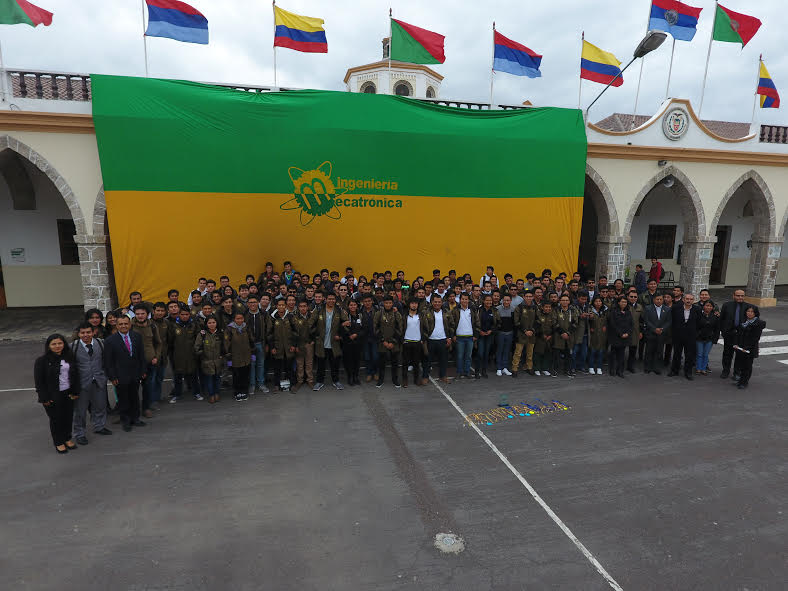

Forma del vector de entrada: (591, 788, 3)


In [144]:
import cv2
from PIL import Image
from IPython.display import display

imagen = cv2.imread("Imágenes/mct_personas.jpg")
imagen_mostrar = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) # Convetir de BGR a RGB
display(Image.fromarray(imagen_mostrar)) 
print("Forma del vector de entrada: {}".format(imagen.shape))

### Cambiando la forma del vector de entrada
A través de las operaciones de matrices como la operación de `resize`, `transpose` y `reshape` del paquete numpy, podremos cambiar la forma del actual vector de entrada que es de la forma `(591, 788, 3)` hacia la forma objetivo que es  `(1, 3, 320, 544)`. En orden se va a hacer lo siguiente:
- Cambiar el tamaño del ancho y  alto de (591, 788) a (320, 544)
- Transponer las columnas del vector, del orden de nuestra imagen `(0, 1, 2)` hacia el `(2, 0, 1)`
- Añadir una nueva columna al inicio del vector para formar el vector (B, C, H, W)

El procedimiento se describe en la siguiente función:

In [151]:
import numpy as np
def preparar_array_entrada(imagen, forma_vector_entrada):
    #Formato OPENCV: H, W, C
    #Formato Capa Entrada: B, C, H, W
    imagen_correcta_alto_ancho = (forma_vector_entrada[3], forma_vector_entrada[2]) 
    imagen_correcta_entrada = cv2.resize(imagen, imagen_correcta_alto_ancho) #Resize argumento (W, H)
    imagen_correcta_entrada = np.transpose(imagen_correcta_entrada, (2, 0, 1))
    imagen_correcta_entrada = np.reshape(imagen_correcta_entrada, tuple(forma_vector_entrada))
    return imagen_correcta_entrada

Esta función hace lo que se estableció en el anterior párrafo, ahora es hora de realizar la inferencia sea de forma síncrona o asíncrona

###  Inferencia Síncrona

Esta inferencia es directa y permite obtener el resultado de la inferencia, pero primero, se ha definido una función para graficar los rectangulos de detección con sus porcentajes de acierto.

In [168]:
import numpy as np
def dibujar_rectangulos(imagen, resultado_inferencia, umbral = 0.5):
    """
        Argumentos: 
        imagen: Imagen a la que se le dibujara los rectangulos
        resultado_inferencia: Resultado de la inferencia
        umbral: Minima confidencia que debe tener el resultado para ser aceptado
    """
    #Debido que la forma del resultado es 1, 1, N, 7
    imagen_resultado = imagen.copy()
    amarillo = (11,223,253)
    verde = (33,166,96)
    alto_imagen, ancho_imagen = imagen.shape[0:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    for deteccion in resultado_inferencia[0][0]:
         #Debido a que el resultado es [image_id, label, conf, x_min, y_min, x_max, y_max]
         if float(deteccion[2]) >= umbral: #Detecciones que son seguras
            x1 = int(deteccion[3]*ancho_imagen)
            y1 = int(deteccion[4]*alto_imagen)
            x2 = int(deteccion[5]*ancho_imagen)
            y2 = int(deteccion[6]*alto_imagen)
            imagen_resultado = cv2.rectangle(imagen_resultado, (x1, y1), (x2, y2), amarillo, 1)
            imagen_resultado = cv2.putText(imagen_resultado, str("{:.2f}".format(deteccion[2])), (x1, y2), font, fontScale, verde, thickness, cv2.LINE_AA)
    return imagen_resultado     

En la inferencia síncrona, se espera hasta que el resultado este listo, tienen la desventaja que bloquean el Thread principal, y solo un frame puede ser proceado a la vez, el final de este programa procede con la grafica.

Forma imagen corregida: (1, 3, 320, 544)


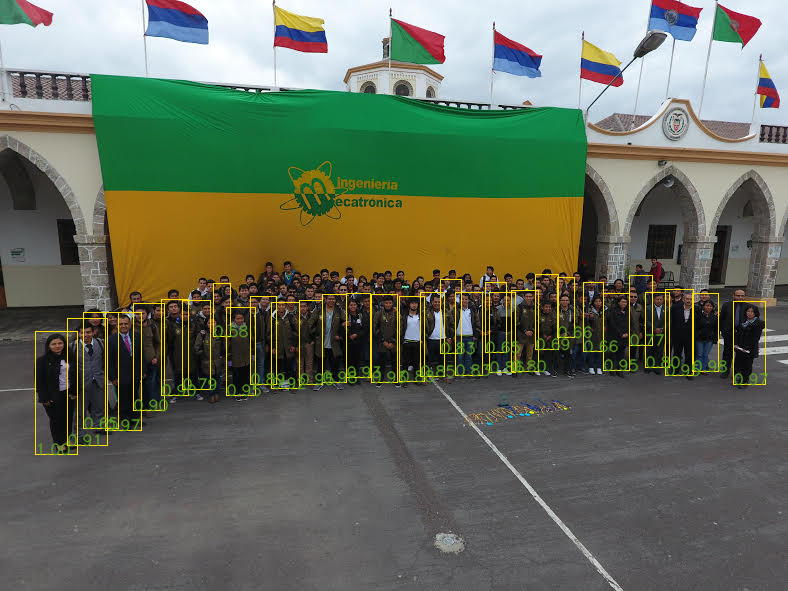

In [169]:
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
nombre_capa_salida = next(iter(network.outputs))
forma_capa_salida = network.outputs[nombre_capa_salida].shape
imagen_corregida = preparar_array_entrada(imagen, forma_capa_entrada)
print("Forma imagen corregida: {}".format(imagen_corregida.shape))
resultado = exec_network.infer({nombre_capa_entrada: imagen_corregida}) #Enviar como diccionario con el nombre de la capa de entrada
imagen_procesada = dibujar_rectangulos(imagen, resultado[nombre_capa_salida]) #Enviar solo como array
imagen_mostrar_resultado = cv2.cvtColor(imagen_procesada, cv2.COLOR_BGR2RGB) # Convetir de BGR a RGB
display(Image.fromarray(imagen_mostrar_resultado)) 

## Inferencia Asíncrona
Este tipo de inferencia, el Thread principal no se bloquea pues se envia la solicitud de inferencia y el programa puede hacer otras actividades como por ejemplo pre-procesar el frame anterior, de esa manera se gana tiempo y cuando el resultado está listo, por software con el método `wait` de la `ExecutableNetwork` notifica al programa. Además se puede añadir un id de solicitud de inferencia, en el caso que se trabaje con más de una. Esta implementanción es perfecta para entornos de programación de Multihilo o Interfaces gráficas de usuario. En el código siguiente, se muestra una implementación sencilla.

Forma imagen corregida: (1, 3, 320, 544)


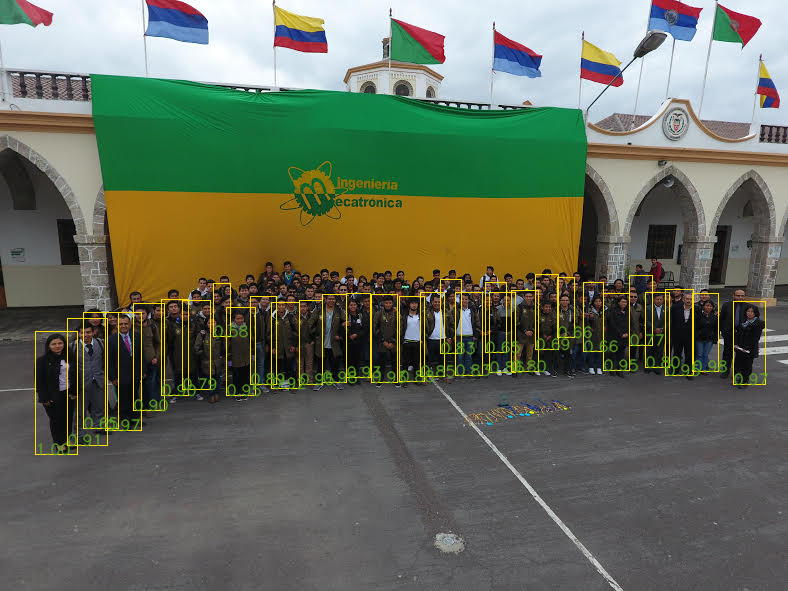

In [173]:
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
nombre_capa_salida = next(iter(network.outputs))
forma_capa_salida = network.outputs[nombre_capa_salida].shape
imagen_corregida = preparar_array_entrada(imagen, forma_capa_entrada)
print("Forma imagen corregida: {}".format(imagen_corregida.shape))
#Inicia la inferencia asincrona
estado_inferencia_handler = exec_network.start_async(request_id = 0, inputs = {nombre_capa_entrada: imagen_corregida}) #Enviar como diccionario con el nombre de la capa de entrada
#Espera hasta que este listo el resultado
estado_inferencia = estado_inferencia_handler.wait()
#Recibe el resultado
resultado = estado_inferencia_handler.output_blobs[nombre_capa_salida]
imagen_procesada = dibujar_rectangulos(imagen, resultado.buffer) #Enviar solo como array
imagen_mostrar_resultado = cv2.cvtColor(imagen_procesada, cv2.COLOR_BGR2RGB) # Convetir de BGR a RGB
display(Image.fromarray(imagen_mostrar_resultado)) 

## Referencias
- [1] Intel. (2021, Agosto 31).Supported Framework Layers. Intel. [https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_prepare_model_Supported_Frameworks_Layers.html](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_prepare_model_Supported_Frameworks_Layers.html)
- [2] Intel. (2021, Agosto 31). ie_api.ExecutableNetwork Class Reference. Intel. [https://docs.openvinotoolkit.org/2021.4/ie_python_api/classie__api_1_1ExecutableNetwork.html](https://docs.openvinotoolkit.org/2021.4/ie_python_api/classie__api_1_1ExecutableNetwork.html)
- [3] Intel. (2021, Agosto 31). ie_api.IENetwork Class Reference. Intel. [https://docs.openvinotoolkit.org/2021.4/ie_python_api/classie__api_1_1IENetwork.html](https://docs.openvinotoolkit.org/2021.4/ie_python_api/classie__api_1_1IENetwork.html)